In [330]:
from Transformer import EasyTransformer
from Transformer_config import EasyTransformerConfig
from experiments import *
from train import *
import torch
from dataclasses import dataclass
from typing import Optional, Callable
from torch.utils.data import Dataset, DataLoader
import pickle
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
test['time'] = test['dt'].dt.time

/tmp/ipykernel_274761/1785179798.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['time'] = test['dt'].dt.time


In [16]:
test['sign'] = np.where( # Use three-way classification to avoid unbalanced set problem
            test['label'] > 0, 2, 
            np.where(test['label'] == 0, 1, 0)
        )

/tmp/ipykernel_274761/3623691117.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['sign'] = np.where( # Use three-way classification to avoid unbalanced set problem


In [20]:
# Check percentage of classes 0, 1, 2 for each time of the day:

# zero_counts = test.groupby('time').apply(lambda x: (x['sign']==0).sum())

one_counts = test.groupby('time').apply(lambda x: (x['sign']==1).sum())

two_counts = test.groupby('time').apply(lambda x: (x['sign']==2).sum())

/tmp/ipykernel_274761/4085033956.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  one_counts = test.groupby('time').apply(lambda x: (x['sign']==1).sum())
/tmp/ipykernel_274761/4085033956.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  two_counts = test.groupby('time').apply(lambda x: (x['sign']==2).sum())


In [25]:
counts = pd.concat([zero_counts, one_counts, two_counts], axis=1)

In [36]:
counts / 2065993

,0,1,2
time,,,
14:30:00,0.387472,0.226339,0.386189
15:00:00,0.381096,0.234904,0.383999
15:30:00,0.373958,0.245304,0.380738
16:00:00,0.379536,0.250758,0.369706
16:30:00,0.373740,0.257458,0.368802
17:00:00,0.361926,0.260158,0.377917
17:30:00,0.378403,0.257664,0.363933
18:00:00,0.367369,0.256737,0.375894
18:30:00,0.373248,0.241845,0.384907


# Prepare Test data

In [2]:
with open('../data/test_DL.pkl', 'rb') as file:
    test = pickle.load(file)

In [6]:
# Get last 2.5M obs:
test = test.iloc[-2500000:]


In [31]:
sequences = [] #torch.empty(len(test), 43, 5)
targets = [] #torch.empty(len(test), 43)

for i, batch in tqdm(enumerate(dataloader), total=len(test_dataset)//2048):
    inputs, labels = batch
    sequences.append(inputs) # sequences[i:i+2048, :, :] = inputs
    targets.append(labels) # targets[i, :] = labels
    

1221it [35:40,  1.75s/it]                          


In [42]:
sequences

tensor([[[ 0.0000e+00,  4.0850e+01,  4.0850e+01,  4.2036e-03,  0.0000e+00],
         [-6.1218e-04,  4.1050e+01,  4.0730e+01,  3.8489e-03,  3.5797e+05],
         [-2.2070e-03,  4.0850e+01,  4.0700e+01,  3.8316e-03,  2.5415e+05],
         ...,
         [-6.0123e-05,  4.1580e+01,  4.1580e+01,  1.7989e-03,  3.4811e+04],
         [ 0.0000e+00,  4.1580e+01,  4.1580e+01,  1.7989e-03,  0.0000e+00],
         [ 0.0000e+00,  4.1580e+01,  4.1580e+01,  1.7989e-03,  3.0460e+03]],

        [[-2.2336e-03,  2.2363e+01,  2.2360e+01,  3.7937e-03,  3.9700e+02],
         [ 0.0000e+00,  2.2360e+01,  2.2360e+01,  3.7937e-03,  0.0000e+00],
         [ 0.0000e+00,  2.2410e+01,  2.2360e+01,  3.7937e-03,  1.0690e+03],
         ...,
         [-6.6860e-03,  2.2450e+01,  2.2360e+01,  2.9106e-03,  8.2500e+02],
         [-1.7905e-03,  2.2320e+01,  2.2320e+01,  2.9229e-03,  2.3200e+02],
         [-4.0404e-03,  2.2270e+01,  2.2230e+01,  2.9681e-03,  6.7200e+02]],

        [[ 1.4979e-03,  3.0531e+01,  3.0531e+01,  1.1125

In [41]:
targets

tensor([[0, 0, 2,  ..., 1, 1, 0],
        [1, 1, 0,  ..., 0, 0, 1],
        [0, 1, 2,  ..., 1, 2, 2],
        ...,
        [0, 0, 2,  ..., 2, 0, 0],
        [2, 0, 0,  ..., 0, 2, 0],
        [0, 1, 1,  ..., 0, 0, 2]])

In [36]:
sequences = torch.cat(sequences, dim=0)
targets = torch.cat(targets, dim=0)

In [43]:
torch.save(sequences, '../data/test_inputs_DL.pth')

In [44]:
torch.save(targets, '../data/test_targets_DL.pth')

# Experiments

In [347]:
# cfg = EasyTransformerConfig(n_layers = 3,
#             d_in = 5,
#             d_model = 20,
#             n_ctx = 43,
#             d_head = 5,
#             model_name = "custom",
#             n_heads = 4,
#             d_mlp = 64,
#             act_fn = 'relu',
#             eps = 1e-5,
#             use_attn_scale = True, # whether to explicitly calculate the amount each head adds to the residual stream (with a hook) and THEN add it up, vs just calculating the sum. This can be very memory intensive for large models, so defaults to False
#             init_mode = "gpt2",
#             normalization_type = 'LN',
#             device = "cuda" if torch.cuda.is_available() else "cpu",
#             attention_dir = "causal",
#             seed = 42,
#             initializer_range = -1.0, # This will set: self.initializer_range = 0.8 / np.sqrt(self.d_model)
#             positional_embedding_type = "standard",
#             d_vocab_out = 3
#         ) # For three-way prediction

cfg = EasyTransformerConfig(n_layers = 3,
            d_in = 5,
            d_model = 50,
            n_ctx = 43,
            d_head = 10,
            model_name = "custom",
            n_heads = 5,
            d_mlp = 100,
            act_fn = 'relu',
            eps = 1e-5,
            use_attn_scale = True, # whether to explicitly calculate the amount each head adds to the residual stream (with a hook) and THEN add it up, vs just calculating the sum. This can be very memory intensive for large models, so defaults to False
            init_mode = "gpt2",
            normalization_type = 'LN',
            device = "cuda" if torch.cuda.is_available() else "cpu",
            attention_dir = "causal",
            seed = 42,
            initializer_range = -1.0, # This will set: self.initializer_range = 0.8 / np.sqrt(self.d_model)
            positional_embedding_type = "standard",
            d_vocab_out = 3
        ) # For three-way prediction


model = EasyTransformer(cfg)

# Load learned model parameters:
#model.load_state_dict(torch.load('../trained_models_DL/model_8000.pt', map_location=torch.device('cpu')))

model.load_state_dict(torch.load('../trained_models_DL/model_8000_II.pt', map_location=torch.device('cpu')))


Moving model to device:  cpu


/tmp/ipykernel_28290/2414520053.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../trained_models_DL/model_8000_II.pt', map_location=t

<All keys matched successfully>

In [348]:
dataset = torch.load('../data/test_inputs_DL.pth')[-250000:]#[-1000000:] # Reduce sample size for memory overload
targets = torch.load('../data/test_targets_DL.pth')[-250000:]#[-1000000:]

criterion = nn.CrossEntropyLoss()

use_accuracy = True

# Define metric function
def metric_func(model, dataset):
    total_loss = 0

    with torch.no_grad():
        logits = model(dataset) # Return logits for CE loss with sign prediction

        if use_accuracy:
            predictions = torch.argmax(logits, dim=-1)

            accuracy = (predictions == targets).float().mean()
            return accuracy

        loss = criterion(logits.view(-1, 3), targets.view(-1))
        
        total_loss += loss.item()
        
    return torch.tensor(total_loss / len(dataset))


/tmp/ipykernel_28290/2481766378.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load('../data/test_inputs_DL.pth')[-250000:]#[-1000000:] # Reduce sample 

# Accuracy by class

In [ ]:
with torch.no_grad():
    output = model(dataset)

    # Get predictions from the model
    predictions = torch.argmax(output, dim=-1)
    
    # Create a mask where the target is not equal to 0
    mask = (targets == 2)
    
    # Compute the accuracy only for the non-zero targets
    correct_predictions = (predictions == targets) * mask
    accuracy = correct_predictions.sum() / mask.sum()

In [19]:
accuracy

tensor(0.5275)

In [23]:
accuracy # excluding zeros

tensor(0.4069)

In [13]:
accuracy # positive

tensor(0.2634)

In [11]:
accuracy # Zero

tensor(0.7703)

In [8]:
accuracy # negative

tensor(0.5532)

In [19]:
accuracy # Overall

tensor(0.5323)

# Ablation:

In [8]:
metric = ExperimentMetric(metric=metric_func, dataset=dataset)


abl_config = AblationConfig(
    abl_type ="mean",  # Example: mean ablation
    target_module="attn_head",
    layers=(0, 3),  # Ablate layers 0 to 3
    heads=[0, 1, 2, 3, 4],  # Specific heads to ablate
    mean_dataset=dataset,
    verbose=True,
)

# Initialize and Run Ablation Experiment
ablation_exp = EasyAblation(model=model, config=abl_config, metric=metric)
results = ablation_exp.run_ablation()


--- AblationConfig: ---
* nb_metric_iteration: 1
* target_module: attn_head
* head_circuit: z
* layers: (0, 3)
* heads: [0, 1, 2, 3, 4]
* dataset: tensor([[-3.3484e-04,  4.4816e+01,  4.4770e+01,  2.9449e-03,  3.6099e+05],
        [ 0.0000e+00,  4.4800e+01,  4.4760e+01,  2.9446e-03,  8.6266e+05],
        [-2.2329e-04,  4.4790e+01,  4.4780e+01,  2.9446e-03,  5.6930e+03],
        [ 0.0000e+00,  4.4780e+01,  4.4780e+01,  2.9446e-03,  0.0000e+00],
        [ 0.0000e+00,  4.4780e+01,  4.4780e+01,  2.9025e-03,  0.0000e+00],
        [ 1.3412e-03,  4.4850e+01,  4.4810e+01,  2.4280e-03,  3.1664e+05],
        [-1.4529e-03,  4.4855e+01,  4.4770e+01,  2.4242e-03,  6.4188e+05],
        [ 1.1166e-04,  4.4785e+01,  4.4740e+01,  2.3980e-03,  3.8980e+05],
        [-3.3503e-04,  4.4800e+01,  4.4754e+01,  2.3810e-03,  2.4516e+06],
        [ 1.7871e-05,  4.4790e+01,  4.4730e+01,  2.3641e-03,  4.1234e+05]]) ... 
tensor([[ 1.5469e-02,  4.8595e+01,  4.8300e+01,  4.3078e-03,  4.7891e+04],
        [ 3.3938e-03, 

100%|██████████| 3/3 [06:01<00:00, 120.42s/it]


In [6]:
-results_II # Large model second exp

tensor([[0.0454, 0.0282, 0.0404, 0.1239, 0.0447],
        [0.0534, 0.0424, 0.0263, 0.0358, 0.0370],
        [0.0754, 0.2055, 0.0588, 0.0170, 0.0251]])

In [9]:
-results # Large model first exp

tensor([[0.0453, 0.0284, 0.0401, 0.1248, 0.0449],
        [0.0535, 0.0421, 0.0267, 0.0354, 0.0372],
        [0.0754, 0.2054, 0.0589, 0.0164, 0.0252]])

In [5]:
results

tensor([[0.0648, 0.2084, 0.0719, 0.1124],
        [0.0553, 0.0422, 0.0374, 0.0486],
        [0.0553, 0.0302, 0.1541, 0.1655]])

In [10]:
# torch.save(-results, '../results_DL/mean_ablation_head_imp_model_2_accuracy.pth')

In [103]:
results

tensor([[0.0469, 0.2498, 0.0441, 0.0431],
        [0.0388, 0.0314, 0.0239, 0.0284],
        [0.0561, 0.0275, 0.0858, 0.1775]])

In [20]:
hooks = list(ablation_exp.mean_cache.keys())

In [21]:
hooks

['blocks.0.hook_resid_pre',
 'blocks.0.attn.ln1.hook_scale',
 'blocks.0.attn.ln1.hook_normalized',
 'blocks.0.attn.hook_q',
 'blocks.0.attn.hook_k',
 'blocks.0.attn.hook_v',
 'blocks.0.attn.hook_attn_scores',
 'blocks.0.attn.hook_attn',
 'blocks.0.attn.hook_z',
 'blocks.0.hook_attn_out',
 'blocks.0.hook_resid_mid',
 'blocks.0.ln2.hook_scale',
 'blocks.0.ln2.hook_normalized',
 'blocks.0.mlp.hook_pre',
 'blocks.0.mlp.hook_post',
 'blocks.0.hook_mlp_out',
 'blocks.0.hook_resid_post',
 'blocks.1.hook_resid_pre',
 'blocks.1.attn.ln1.hook_scale',
 'blocks.1.attn.ln1.hook_normalized',
 'blocks.1.attn.hook_q',
 'blocks.1.attn.hook_k',
 'blocks.1.attn.hook_v',
 'blocks.1.attn.hook_attn_scores',
 'blocks.1.attn.hook_attn',
 'blocks.1.attn.hook_z',
 'blocks.1.hook_attn_out',
 'blocks.1.hook_resid_mid',
 'blocks.1.ln2.hook_scale',
 'blocks.1.ln2.hook_normalized',
 'blocks.1.mlp.hook_pre',
 'blocks.1.mlp.hook_post',
 'blocks.1.hook_mlp_out',
 'blocks.1.hook_resid_post',
 'blocks.2.hook_resid_pre',


# Patching:

In [ ]:
# Initialize Configuration
# Initialize Metric
patch_metric = ExperimentMetric(
    metric=metric_func,  # Callable to compute metrics
    dataset=dataset,  # Evaluate on target dataset
    relative_metric=True  # Normalize against baseline
)


patch_cfg = PatchingConfig(
    source_dataset=source_data,  # Source dataset for activations
    target_dataset=target_data,  # Dataset to evaluate patching effects
    patch_fn=cst_fn,  # Default: replace with source activations
    cache_act=True,   # Cache activations for efficiency
    layers=[0, 1, 2],  # Target layers for patching
    heads=[0, 1],      # Target heads
)

# Initialize Patching Experiment
patch_experiment = EasyPatching(model=model, config=patch_cfg, metric=patch_metric)

# Run Experiment
results = patch_experiment.run_patching()

# View Results
print(results)


# Visualizations

In [132]:
results = torch.load('../results_DL/mean_ablation_head_imp_model_2_accuracy.pth')

/tmp/ipykernel_41999/2168779779.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results = torch.load('../results_DL/mean_ablation_head_imp_model_2_accuracy.pth')


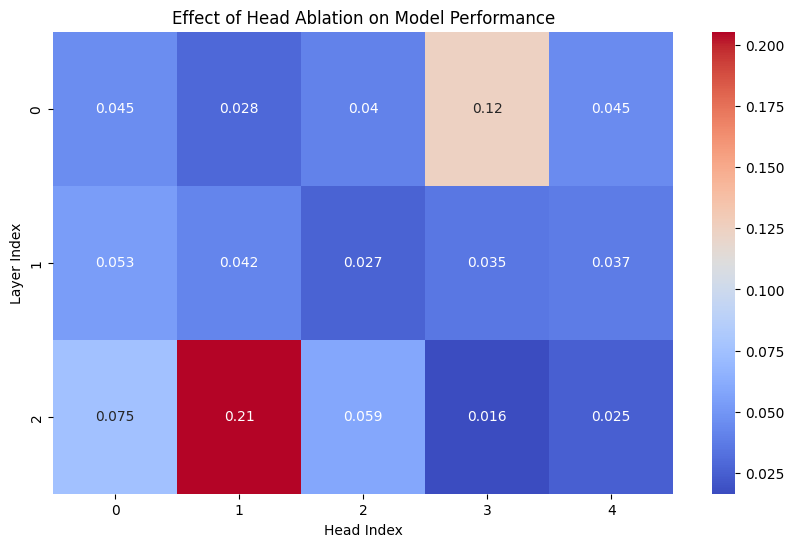

In [123]:
num_heads = 5
num_layers = 3

# Prepare data for heatmap
layer_head_matrix = [
    [results[i, j] for j in range(num_heads)]
    for i in range(num_layers)
]

plt.figure(figsize=(10, 6)) 
# Plot heatmap
sns.heatmap(layer_head_matrix, annot=True, cmap="coolwarm", cbar=True)
plt.title("Effect of Head Ablation on Model Performance")
plt.xlabel("Head Index")
plt.ylabel("Layer Index")
plt.savefig("../results_DL/heatmap_model_2.png", dpi=300, bbox_inches="tight")  # Save with high resolution
plt.show()


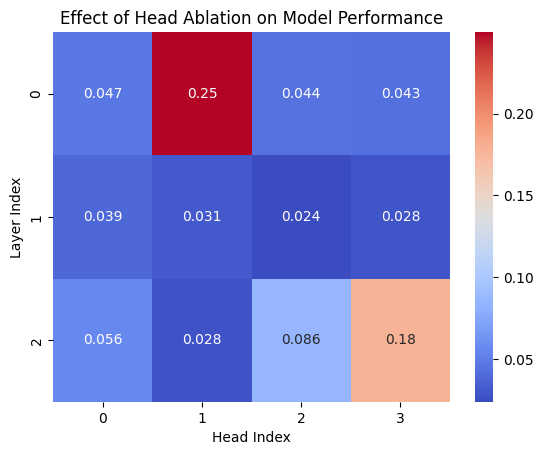

In [114]:
num_heads = 4
num_layers = 3

# Prepare data for heatmap
layer_head_matrix = [
    [results[i, j] for j in range(num_heads)]
    for i in range(num_layers)
]

# Plot heatmap
sns.heatmap(layer_head_matrix, annot=True, cmap="coolwarm", cbar=True)
plt.title("Effect of Head Ablation on Model Performance")
plt.xlabel("Head Index")
plt.ylabel("Layer Index")
plt.savefig("../results_DL/heatmap_model_1.png", dpi=300, bbox_inches="tight")  # Save with high resolution
plt.show()


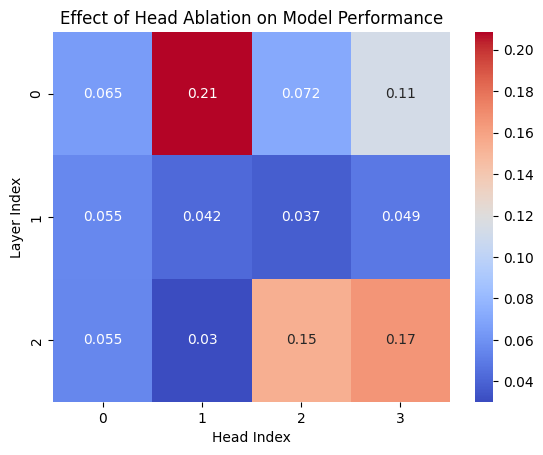

In [117]:
num_heads = 4
num_layers = 3

# Prepare data for heatmap
layer_head_matrix = [
    [results[i, j] for j in range(num_heads)]
    for i in range(num_layers)
]

# Plot heatmap
sns.heatmap(layer_head_matrix, annot=True, cmap="coolwarm", cbar=True)
plt.title("Effect of Head Ablation on Model Performance")
plt.xlabel("Head Index")
plt.ylabel("Layer Index")
plt.savefig("../results_DL/heatmap_model_1_ce_metric.png", dpi=300, bbox_inches="tight")  # Save with high resolution

plt.show()


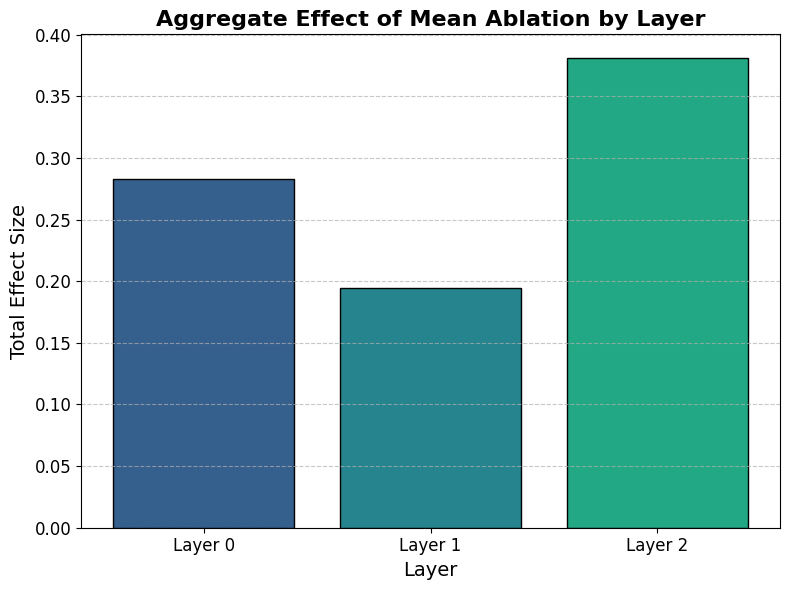

In [134]:
# Example data
num_heads = 5
num_layers = 3

# Aggregate effect size by layer
layer_effects = [
    sum(results[i, j] for j in range(num_heads))
    for i in range(num_layers)
]

# Set figure size
plt.figure(figsize=(8, 6))

# Bar chart
bar_colors = plt.cm.viridis(np.linspace(0.3, 0.6, num_layers))
plt.bar(range(len(layer_effects)), layer_effects, color=bar_colors, edgecolor='black')

# Add title and axis labels
plt.title("Aggregate Effect of Mean Ablation by Layer", fontsize=16, fontweight="bold")
plt.xlabel("Layer", fontsize=14)
plt.ylabel("Total Effect Size", fontsize=14)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customize ticks
plt.xticks(range(len(layer_effects)), labels=[f"Layer {i}" for i in range(num_layers)], fontsize=12)
plt.yticks(fontsize=12)

plt.savefig("../results_DL/layer_importance_model_2.png", dpi=300, bbox_inches="tight")  # Save with high resolution

# Show the plot
plt.tight_layout()  # Ensures everything fits nicely
plt.show()


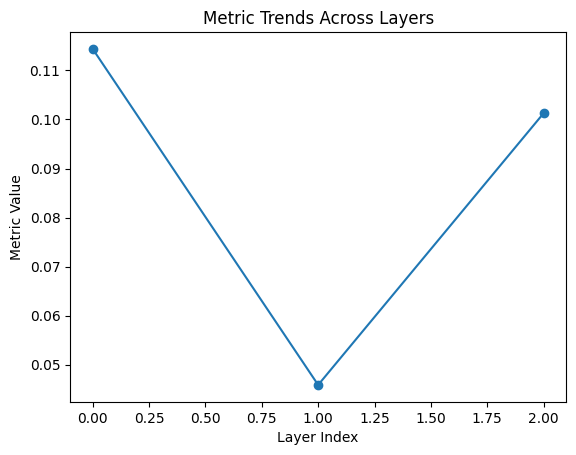

In [15]:
# Compute average metric per layer
layer_metrics = [
    sum(results[i, j] for j in range(num_heads)) / len(results[i])
    for i in range(num_layers)
]

# Plot line chart
plt.plot(range(len(layer_metrics)), layer_metrics, marker='o')
plt.title("Metric Trends Across Layers")
plt.xlabel("Layer Index")
plt.ylabel("Metric Value")
plt.show()


# Attention Study

In [379]:
# Run model with caching hooks and return activation cache:

with torch.no_grad():
    output, activation_cache = model.run_with_cache(dataset)


In [455]:
for key in activation_cache.cache_dict.keys():
    activation_cache.cache_dict[key] = torch.mean(activation_cache.cache_dict[key], dim=0)

In [42]:
import pickle

# with open("../results_DL/activation_cache_model_2.pkl", "wb") as f:
#     pickle.dump(activation_cache.cache_dict, f)

# with open("../results_DL/activation_cache_model_1.pkl", "rb") as f:
#     loaded_dict = pickle.load(f)

In [15]:
activation_keys = activation_cache.cache_dict.keys()

In [18]:
activation_keys

dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.attn.ln1.hook_scale', 'blocks.0.attn.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_attn', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.attn.ln1.hook_scale', 'blocks.1.attn.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_attn', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_resi

In [24]:
activation_cache.cache_dict['blocks.0.attn.hook_attn'].shape

torch.Size([1000000, 4, 43, 43])

In [75]:
activation_cache.cache_dict['blocks.0.attn.hook_attn'][:, :, :].shape

torch.Size([4, 43, 43])

## Larger model

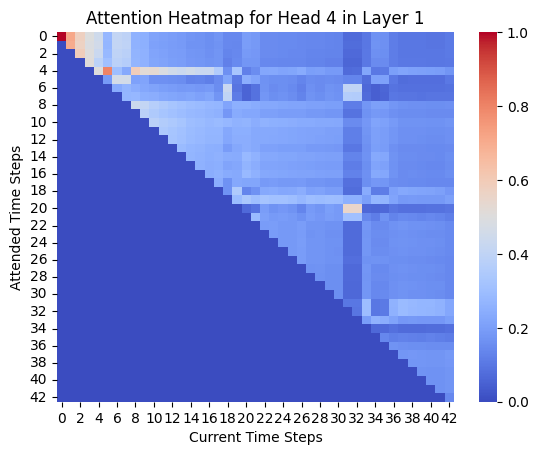

In [454]:
# Larger model: with more heads per layer specialization occurs earlier in the network:
# head 4 focusing on intra-day information and head 3 capturing eod steps
sns.heatmap(torch.sqrt(activation_cache.cache_dict['blocks.2.attn.hook_attn'][8000, 1, :, :].T), cmap="coolwarm", cbar=True)
plt.title("Attention Heatmap for Head 4 in Layer 1")
plt.xlabel("Current Time Steps")
plt.ylabel("Attended Time Steps")
#plt.savefig("../results_DL/att_H4_L1_model_2_second_pattern.png", dpi=300, bbox_inches="tight")  # Save with high resolution

plt.show()

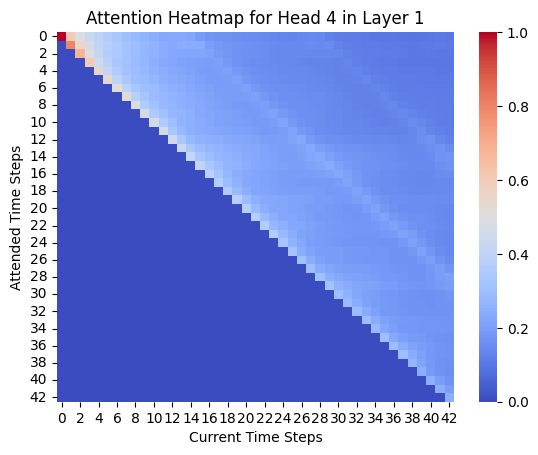

In [329]:
# Larger model: with more heads per layer specialization occurs earlier in the network:
# head 4 focusing on intra-day information and head 3 capturing eod steps
sns.heatmap(torch.sqrt(activation_cache.cache_dict['blocks.2.attn.hook_attn'][1, :, :].T), cmap="coolwarm", cbar=True)
plt.title("Attention Heatmap for Head 4 in Layer 1")
plt.xlabel("Current Time Steps")
plt.ylabel("Attended Time Steps")
plt.savefig("../results_DL/avg_att_H2_L3_model_2.png", dpi=300, bbox_inches="tight")  # Save with high resolution

plt.show()

## Smaller model

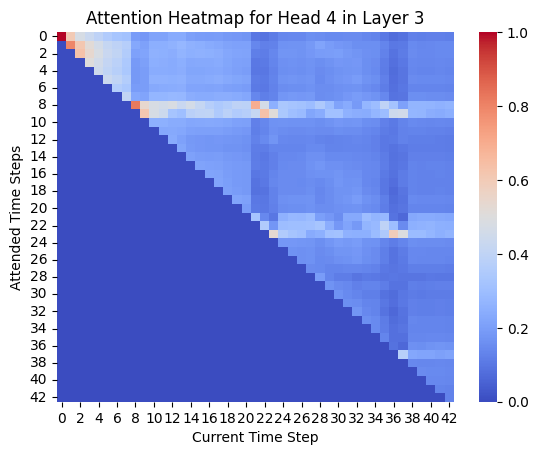

In [216]:
sns.heatmap(torch.sqrt(activation_cache.cache_dict['blocks.0.attn.hook_attn'][600000, 1, :, :].T), cmap="coolwarm", cbar=True)
plt.title("Attention Heatmap for Head 4 in Layer 3")
plt.xlabel("Current Time Step")
plt.ylabel("Attended Time Steps")
#plt.savefig("../results_DL/att_H4_L3_model_1_first_pattern.png", dpi=300, bbox_inches="tight")  # Save with high resolution

plt.show()

In [ ]:
300000 (second pattern), 600000 (first pattern) # Investigate how are these datapoints structured

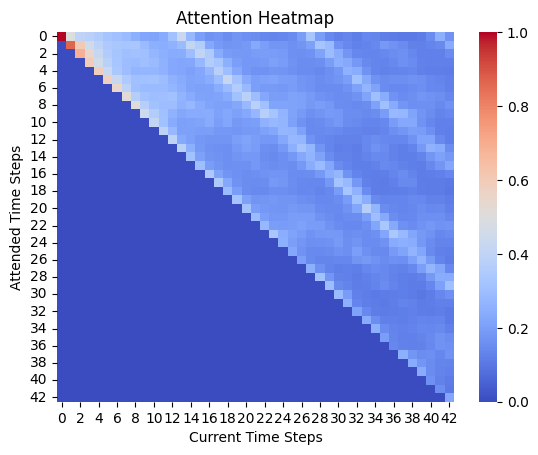

In [236]:
sns.heatmap(torch.sqrt(activation_cache.cache_dict['blocks.0.attn.hook_attn'][1, :, :].T), cmap="coolwarm", cbar=True)
plt.title("Attention Heatmap")
plt.xlabel("Current Time Steps")
plt.ylabel("Attended Time Steps")
plt.savefig("../results_DL/avg_att_H2_L1_model_1.png", dpi=300, bbox_inches="tight")  # Save with high resolution

plt.show()

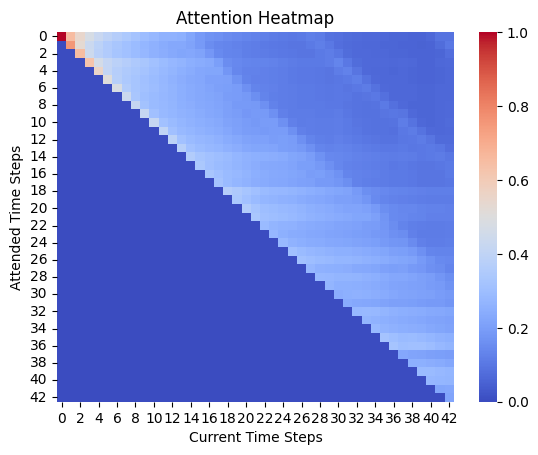

In [238]:
sns.heatmap(torch.sqrt(activation_cache.cache_dict['blocks.2.attn.hook_attn'][2, :, :].T), cmap="coolwarm", cbar=True)
plt.title("Attention Heatmap")
plt.xlabel("Current Time Steps")
plt.ylabel("Attended Time Steps")
plt.savefig("../results_DL/avg_att_H4_L3_model_1.png", dpi=300, bbox_inches="tight")  # Save with high resolution

plt.show()

# Arrow Attention visualization

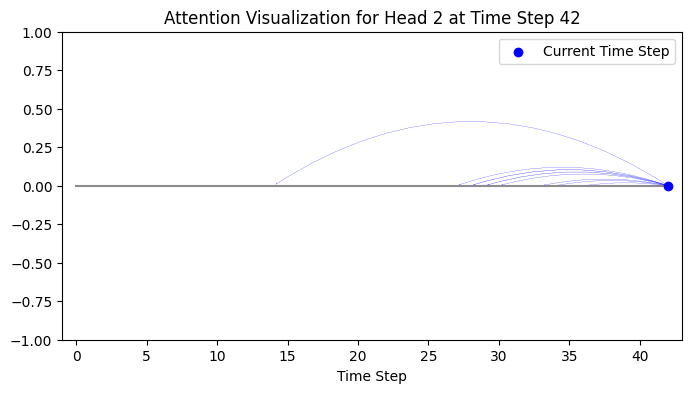

In [456]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.patches import FancyArrowPatch


def visualize_bent_attention_frame(attention_weights, time_steps, current_time_step, head, ax, top_k=10, max_bend=0.5):
    """
    Helper function to visualize attention for a single time step on the provided axis.
    """
    ax.clear()  # Clear the axis for a fresh frame

    # Draw the horizontal time line
    ax.plot(time_steps, [0] * len(time_steps), linestyle='-', color='gray', alpha=0.9)

    # Get the top-k indices with the largest attention weights for the current time step
    top_indices = np.argsort(attention_weights[current_time_step])[-top_k:]
    
    for idx in top_indices:
        # Get the attention weight
        weight = attention_weights[current_time_step, idx]
        
        # Normalize the weights for visibility
        normalized_weight = weight / np.sum(attention_weights[current_time_step])
        
        # Calculate the bend height proportional to the distance between the time steps
        bend_height = max_bend * (current_time_step - idx) / len(time_steps)
        
        # Create a curved arrow
        arrow = FancyArrowPatch(
            (time_steps[current_time_step], 0), (time_steps[idx], 0),
            connectionstyle=f"arc3,rad={bend_height}",
            arrowstyle='-|>', color='blue', lw=5 * normalized_weight
        )
        ax.add_patch(arrow)
    
    # Highlight the current time step
    ax.scatter([time_steps[current_time_step]], [0], color='blue', label='Current Time Step', zorder=3)
    
    # Set plot limits and labels
    ax.set_xlim(time_steps[0] - 1, time_steps[-1] + 1)
    ax.set_ylim(-max_bend * 2, max_bend * 2)
    ax.set_xlabel("Time Step")
    ax.set_ylabel("")
    ax.set_title(f"Attention Visualization for Head {head} at Time Step {current_time_step}")
    ax.legend()

def animate_attention(attention_weights, time_steps, head, interval=500, top_k=10, max_bend=0.5):
    """
    Creates an animation of attention visualizations across time steps.

    Args:
        attention_weights (np.ndarray): Attention matrix of shape (time_steps, time_steps).
        time_steps (list): List of time steps (e.g., [1, 2, ..., 43]).
        interval (int): Time interval between frames in milliseconds.
        top_k (int): Number of top attention weights to visualize.
        max_bend (float): Maximum bend height for the curved arrows.
    """
    fig, ax = plt.subplots(figsize=(8, 4))
    
    def update(frame):
        """
        Update function for FuncAnimation.
        """
        visualize_bent_attention_frame(attention_weights, time_steps, frame, head, ax, top_k=top_k, max_bend=max_bend)

    writer = PillowWriter(fps=12)

    anim = FuncAnimation(fig, update, frames=len(time_steps), interval=interval)
    anim.save("attention_visualization_6.gif", writer=writer, dpi=300)

    # Keep a reference to `anim` until after rendering
    plt.show()


time_steps = np.arange(43)
attention_weights = activation_cache.cache_dict['blocks.2.attn.hook_attn'][1, :, :]#[100, 3, :, :]#[300000, 2, :, :]

animate_attention(attention_weights.numpy(), time_steps, head = 2, interval=5000)
